In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

<IPython.core.display.Javascript object>


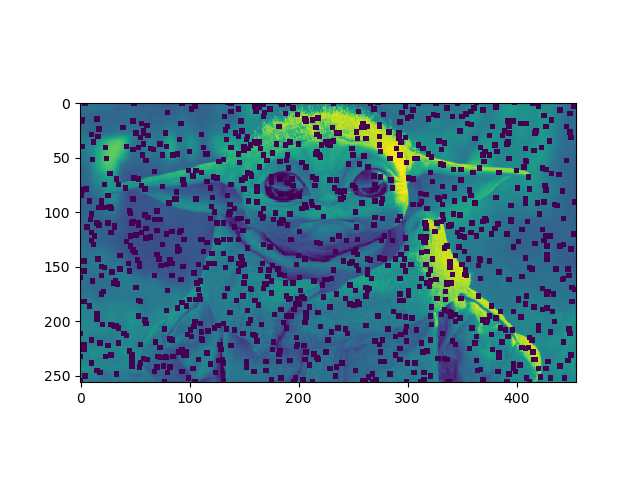

In [124]:
import requests 
import io
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor

res = requests.get('https://images.everyeye.it/img-notizie/the-mandalorian-baby-yoda-vittima-leak-stuntman-spoilerato-fa-v6-483983-1280x720.jpg')
img = Image.open(io.BytesIO(res.content))
x = Compose([Resize(256), ToTensor()])(img)
# x = torch.ones((1, 3, 56, 56))

out = DropBlock(p=0.2)(x)

fig = plt.figure()
plt.imshow(out.squeeze()[1])
plt.show()

In [3]:
class RadixSoftmax(nn.Module):
    def __init__(self, radix, cardinality):
        super(RadixSoftmax, self).__init__()
        self.radix = radix
        self.cardinality = cardinality

    def forward(self, x):
        batch = x.size(0)
        print(f'4) {x.shape}')
        if self.radix > 1:
            x = x.view(batch, self.cardinality, self.radix, -1).transpose(1, 2)
            print(f'5) {x.shape}')
            x = F.softmax(x, dim=1)
            x = x.reshape(batch, -1)
            print(f'6) {x.shape}')
        else:
            x = torch.sigmoid(x)
        return x


class SplitAttnConv2d(nn.Module):
    """Split-Attention Conv2d
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 dilation=1, groups=1, bias=False, radix=2, reduction_factor=4,
                 act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d, drop_block=None, **kwargs):
        super(SplitAttnConv2d, self).__init__()
        self.radix = radix
        self.drop_block = drop_block
        mid_chs = out_channels * radix
        print(mid_chs)
        attn_chs = max(in_channels * radix // reduction_factor, 32)

        self.conv = nn.Conv2d(
            in_channels, mid_chs, kernel_size, stride, padding, dilation,
            groups=groups * radix, bias=bias, **kwargs)
        self.bn0 = norm_layer(mid_chs) if norm_layer is not None else None
        self.act0 = act_layer(inplace=True)
        self.fc1 = nn.Conv2d(out_channels, attn_chs, 1, groups=groups)
        self.bn1 = norm_layer(attn_chs) if norm_layer is not None else None
        self.act1 = act_layer(inplace=True)
        self.fc2 = nn.Conv2d(attn_chs, mid_chs, 1, groups=groups)
        self.rsoftmax = RadixSoftmax(radix, groups)

    @property
    def in_channels(self):
        return self.conv.in_channels

    @property
    def out_channels(self):
        return self.fc1.out_channels

    def forward(self, x):
        x = self.conv(x)
        if self.bn0 is not None:
            x = self.bn0(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act0(x)

        B, RC, H, W = x.shape
        print(f'0) {x.shape}')
        if self.radix > 1:
            x = x.reshape((B, self.radix, RC // self.radix, H, W))
            print(f'1) {x.shape}')
            x_gap = x.sum(dim=1)
            print(f'2) {x_gap.shape}')
        else:
            x_gap = x
        x_gap = F.adaptive_avg_pool2d(x_gap, 1)
        print(f'3) {x_gap.shape}')

        x_gap = self.fc1(x_gap)
        if self.bn1 is not None:
            x_gap = self.bn1(x_gap)
        x_gap = self.act1(x_gap)
        x_attn = self.fc2(x_gap)

        x_attn = self.rsoftmax(x_attn).view(B, -1, 1, 1)
        print(f'x_attn: {x_attn.shape}')
        if self.radix > 1:
            out = (x * x_attn.reshape((B, self.radix, RC // self.radix, 1, 1))).sum(dim=1)
        else:
            out = x * x_attn
        return out.contiguous()

In [4]:
x = torch.randn((3, 64, 28, 28))

split  = SplitAttnConv2d(64, 64, kernel_size=3)
print(split)
split(x).shape

128
SplitAttnConv2d(
  (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), groups=2, bias=False)
  (bn0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act0): ReLU(inplace=True)
  (fc1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (fc2): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
  (rsoftmax): RadixSoftmax()
)
0) torch.Size([3, 128, 26, 26])
1) torch.Size([3, 2, 64, 26, 26])
2) torch.Size([3, 64, 26, 26])
3) torch.Size([3, 64, 1, 1])
4) torch.Size([3, 128, 1, 1])
5) torch.Size([3, 2, 1, 64])
6) torch.Size([3, 128])
x_attn: torch.Size([3, 128, 1, 1])


torch.Size([3, 64, 26, 26])

In [10]:
ResNeSt.resnest14d().encoder.layers[-2]

ResNetLayer(
  (block): Sequential(
    (0): ResNeStBottleneckBlock(
      (block): Sequential(
        (0): ConvBnDropAct(
          (conv): Conv2dPad(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): DropBlock(p=0.2)
          (act): ReLU(inplace=True)
        )
        (1): AvgPool2d(kernel_size=3, stride=2, padding=1)
        (2): ConvBnDropAct(
          (conv): Conv2dPad(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2, bias=False)
          (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): DropBlock(p=0.2)
          (act): ReLU(inplace=True)
        )
        (3): SplitAtt(
          (att): Sequential(
            (0): Reduce('b (r k c) h w -> b (k c) h w', 'mean', r=2, k=1)
            (1): AdaptiveAvgPool2d(output_size=1)
            (2): ConvBnAct(
              (conv): Conv2dPad(2

In [6]:
from glasses.models import ResNet
from glasses.models.classification.resnest import ResNeSt
from functools import partial
from torchsummary import summary

summary(ResNeSt.resnest14d(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Conv2dPad-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
         Conv2dPad-4         [-1, 32, 112, 112]           9,216
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
         Conv2dPad-7         [-1, 64, 112, 112]          18,432
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
        MaxPool2d-10           [-1, 64, 56, 56]               0
        Conv2dPad-11           [-1, 64, 56, 56]           4,096
      BatchNorm2d-12           [-1, 64, 56, 56]             128
        DropBlock-13           [-1, 64, 56, 56]               0
             ReLU-14           [-1, 64,

In [38]:
from torchsummary import summary
import timm
model = timm.create_model('resnest14d')

summary(model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           9,216
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]          18,432
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
        MaxPool2d-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]           4,096
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14          [-1, 128,

In [55]:
timm.list_models('resnest*')

['resnest14d',
 'resnest26d',
 'resnest50d',
 'resnest50d_1s4x24d',
 'resnest50d_4s2x40d',
 'resnest101e',
 'resnest200e',
 'resnest269e']

In [53]:
model = ResNetSt.resnest14d().eval()
model.encoder.features
model(torch.randn((1,3,224,224)))
features = model.encoder.features
print([x.shape for x in features])

[torch.Size([1, 64, 112, 112]), torch.Size([1, 256, 56, 56]), torch.Size([1, 512, 28, 28]), torch.Size([1, 1024, 14, 14])]


In [49]:
from transfer_weights import clone_model
from benchmark import benchmark
from glasses.models.classification.resnest import ResNetSt

src = timm.create_model('resnest50d_1s4x24d')
dst = ResNetSt.resnest50d_1s4x24d()

dst = clone_model(src, dst, torch.randn((1, 3, 224, 224))).eval()

# Benchmark

In [ ]:
from glasses.models import AutoModel, AutoConfig

In [ ]:
type(AutoModel.models())

In [ ]:
cfg = AutoConfig.from_name('resnet18')
cfg.transform

In [ ]:
from glasses.utils.PretrainedWeightsProvider import PretrainedWeightsProvider

In [ ]:
PretrainedWeightsProvider.BASE_DIR

# Clone

In [ ]:
import torch
from glasses.models.classification.vit import ViT
from torch import nn

x = torch.rand((1, 3, 224, 224))
model = ViT.vit_base_patch16_224()
model.encoder.features
model(x)
features = model.encoder.features

In [ ]:
import torch
from glasses.models import AutoModel, AutoConfig, EfficientNetLite
import timm
from transfer_weights import clone_model
from benchmark import benchmark
from glasses.models.classification.vit import ViT

src = timm.create_model('vit_base_patch16_384', pretrained='True')
dst = ViT.vit_base_patch16_384()

# dst = VisionTransformer()
dst = clone_model(src, dst, torch.randn((1, 3, 384, 384))).eval()

In [ ]:
timm.list_models('vit*')

In [ ]:
transform = AutoConfig.from_name('vit_base_patch16_384').transform

benchmark(src.cuda().eval(), transform, batch_size=128)

In [ ]:
dst.embedding.positions.data.copy_(src.pos_embed.data.squeeze(0))
dst.embedding.cls_token.data.copy_(src.cls_token.data)

transform = AutoConfig.from_name('vit_base_patch16_384').transform

benchmark(dst.cuda().eval(), transform, batch_size=128)

In [ ]:
from torchsummary import summary
from glasses.models.classification.vit import ViT

summary(VisionTransformer(), (3, 224, 224), device='cpu')

In [ ]:
summary(timm.create_model('vit_base_patch16_224', pretrained=True), (3, 224, 224), device='cpu')

# Pretrained weights

In [ ]:
from pathlib import Path

root = Path('/home/zuppif/Documents/glasses-weights/')

models = map(lambda x: x.stem, root.glob('*.pth'))

for model in models:
    print(f"'{model}': BasicUrlHandler('https://github.com/FrancescoSaverioZuppichini/glasses-weights/blob/main/{model}.pth?raw=true'),")

## Traced

In [ ]:
from glasses.utils.Tracker import Tracker
import torch

def trace(model, x):
    return Tracker(model)(x)

In [ ]:
x = torch.randn((1, 3, 224, 224))

trace(ViT(), x)

In [ ]:
x = torch.randn((1, 3, 224, 224))

trace(timm.create_model('vit_base_patch16_224', pretrained=True), x).traced

In [ ]:
trace(timm.create_model('vit_base_patch16_224', pretrained=True), x).parametrized

In [ ]:
ViT()

In [ ]:
timm.create_model('vit_base_patch16_224', pretrained=True)